# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2020 semester.

Due date: **October 1st 2020.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/t/42cb56bad41b41f69809f47fef3ee68c.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the NYU classes system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


Kaggle id: DB datacollector
</br> Email id: db4057@nyu.edu

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Mounted at /content/drive
/content/drive/My Drive/assign2_dataset


# Dataloader

In [73]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 100
log_interval = 100

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

Below are some convolution neural networks with different architectures that have been tried out for performance comparision. Run the only the corresponding CNN architecture whose performance to be measured. 

In [4]:
# 2 convolution layers
'''This is just a modification of the provided 2 convolution + pooling layer, 2 fully connected layers. Number of filters have been increased in each
 convolution layer so that more features can be learned and pooling layers are placed after non-linearity. '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3200, 100)
        self.fc2 = nn.Linear(100, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2_drop(self.conv2(x))), 2)
        x = x.view(-1, 3200)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [75]:
# 3 convolution layers
'''One additional convolution layer is added with more filters without pooling. Batch normalization has been added after each convolution layer for 
stablizing the learning process. Also, both secound and third convolution layer as well as the first fully connected layer have dropouts to avoid overfitting.'''
# Best performing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=5)
        self.conv3 = nn.Conv2d(128, 512, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(128)
        self.norm3 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.norm1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.norm2(self.conv2(x))), 2))
        x = F.relu(self.conv2_drop(self.norm3(self.conv3(x))))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

# Training

In [76]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
training_losses = []

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    training_losses.append(loss.item())

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.832434
Train Epoch: 1 [3200/35339 (9%)]	Loss: 2.693984
Train Epoch: 1 [6400/35339 (18%)]	Loss: 1.942589
Train Epoch: 1 [9600/35339 (27%)]	Loss: 2.327693
Train Epoch: 1 [12800/35339 (36%)]	Loss: 1.972183
Train Epoch: 1 [16000/35339 (45%)]	Loss: 0.900776
Train Epoch: 1 [19200/35339 (54%)]	Loss: 1.183156
Train Epoch: 1 [22400/35339 (63%)]	Loss: 0.941035
Train Epoch: 1 [25600/35339 (72%)]	Loss: 1.315749
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.841477
Train Epoch: 1 [32000/35339 (90%)]	Loss: 1.296323
Train Epoch: 1 [35200/35339 (100%)]	Loss: 0.690871

Validation set: Average loss: 0.7932, Accuracy: 2935/3870 (76%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.713818
Train Epoch: 2 [3200/35339 (9%)]	Loss: 0.395008
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.947949
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.624486
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.422038
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.306527
Train Epoch: 2 [19200/

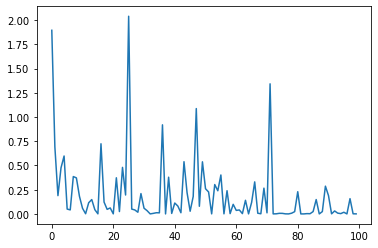

In [77]:
# visualizing the data
import matplotlib.pyplot as plt
plt.plot(training_losses)

# Evaluate and Submit to Kaggle



In [78]:


import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
#model = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model.eval()
for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now take this csv file, download it from your Google drive and then submit it to Kaggle to check performance of your model.